<a href="https://colab.research.google.com/github/priyank9320/text-recognition/blob/main/custom_OCR_fine_tune_SROIE_and_CHINESE_with_set_transform_WORKING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# connect drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install
!pip install -q transformers
!pip install -q datasets jiwer

     |████████████████████████████████| 4.7 MB 14.8 MB/s 
     |████████████████████████████████| 6.6 MB 47.0 MB/s 
     |████████████████████████████████| 120 kB 68.3 MB/s 
     |████████████████████████████████| 365 kB 15.3 MB/s 
     |████████████████████████████████| 212 kB 54.4 MB/s 
     |████████████████████████████████| 115 kB 65.7 MB/s 
     |████████████████████████████████| 127 kB 48.4 MB/s 
     |████████████████████████████████| 1.4 MB 69.7 MB/s 
     |████████████████████████████████| 2.0 MB 66.1 MB/s 
     |████████████████████████████████| 104 kB 61.5 MB/s 


In [ ]:
# import
from transformers import TrainingArguments, Trainer, ViTFeatureExtractor, BertTokenizer, VisionEncoderDecoderModel, AutoTokenizer
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from PIL import Image
from datasets import load_dataset, DatasetDict

In [ ]:
# variables
# model names
vision_model = "google/vit-large-patch32-384"
language_model = "bert-base-multilingual-cased"

Each element of the dataset should return 2 things:
* `pixel_values`, which serve as input to the model.
* `labels`, which are the `input_ids` of the corresponding text in the image.

We use `TrOCRProcessor` to prepare the data for the model. `TrOCRProcessor` is actually just a wrapper around a `ViTFeatureExtractor` (which can be used to resize + normalize images) and a `RobertaTokenizer` (which can be used to encode and decode text into/from `input_ids`). 

In [ ]:
# tokenizer for text
tokenizer =  AutoTokenizer.from_pretrained(language_model)
# feature extractor for image
feature_extractor = ViTFeatureExtractor.from_pretrained(vision_model)

Let's initialize the training and evaluation datasets:

In [ ]:
# download data
hf_full_sroie_data= load_dataset('priyank-m/SROIE_2019_text_recognition', split='test')

hf_sroie_data = hf_full_sroie_data
hf_sroie_data

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/priyank-m___imagefolder/priyank-m--SROIE_2019_text_recognition-3e9f1324f13c6c51/0.0.0/0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff. Subsequent calls will reuse this data.


Dataset({
    features: ['image', 'text'],
    num_rows: 18704
})

In [ ]:
hf_full_chinese_data = load_dataset("priyank-m/chinese_text_recognition", split='val')
hf_chinese_data = hf_full_chinese_data
hf_chinese_data

Downloading:   0%|          | 0.00/888 [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/priyank-m___parquet/priyank-m--chinese_text_recognition-04c1b543d5961b1f/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


Dataset({
    features: ['image', 'text'],
    num_rows: 50000
})

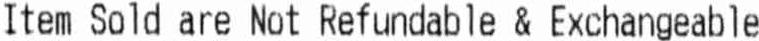

In [ ]:
hf_sroie_data[1]['image']

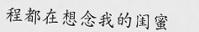

In [ ]:
hf_chinese_data[1]['image']

In [ ]:
hf_sroie_data = hf_sroie_data.shuffle().select(range(2)).train_test_split(test_size=0.5)
hf_sroie_data 

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 1
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 1
    })
})

In [ ]:
# convert to RGB for chinese images
hf_chinese_data = hf_chinese_data.shuffle().select(range(2)).train_test_split(test_size=0.5)

hf_chinese_data = hf_chinese_data.map(lambda example: {'image':example['image'].convert('RGB'), 'text':example['text']})

  0%|          | 0/1 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?ex/s]

In [ ]:
# concat datasets
from datasets import concatenate_datasets
hf_dataset_cc_train = concatenate_datasets([hf_sroie_data['train'], hf_chinese_data['train']])
hf_dataset_cc_test = concatenate_datasets([hf_sroie_data['test'], hf_chinese_data['test']])

hf_dataset_cc = DatasetDict({'train':hf_dataset_cc_train, 'test':hf_dataset_cc_test})
hf_dataset_cc = hf_dataset_cc.shuffle(seed=42)
hf_dataset_cc

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 2
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 2
    })
})

In [ ]:
hf_dataset_cc['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=282x32 at 0x7F899C18F710>,
 'text': '-15击败了赛会头号种子'}

In [ ]:
# # squeeze demo
# pix = feature_extractor(image, return_tensors="pt").pixel_values
# print(pix.shape)
# type(pix.squeeze())
# pix.squeeze().shape

In [ ]:
# pre-processing function
def prep_function(examples, max_target_length=128):
    pixel_values = feature_extractor(examples['image'], return_tensors="pt").pixel_values
    labels = tokenizer(examples['text'], padding="max_length", max_length=max_target_length).input_ids[0]

    labels = [label if label != tokenizer.pad_token_id else -100 for label in labels]
    # new_label = []
    # for label in labels:
    #     if label!=tokenizer.pad_token_id:
    encoding = {"pixel_values": pixel_values, "labels": torch.tensor([labels])} # squeezeis removing the first dimenion which tells the no. of samples

    # here pixel_values is torch.tensor, but once saved in the dataset it becomes a dict
    return encoding

In [ ]:
# on-the-fly preprocessing using set_transform

from datasets import Features, Value, Sequence
hf_dataset_cc.set_transform(prep_function, output_all_columns=True)

train_dataset = hf_dataset_cc['train']
eval_dataset = hf_dataset_cc['test']

In [ ]:
# checking the datatype and dimensions of the data
encoding = train_dataset[1]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


In [ ]:
# checking the decoding works properly
labels = encoding['labels']
labels[labels == -100] = tokenizer.pad_token_id
label_str = tokenizer.decode(labels, skip_special_tokens=True)
print(label_str)

SR @ 6 %


In [ ]:
# length of the datasets
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 2
Number of validation examples: 2


In [ ]:
# model
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    vision_model, language_model
)

Some weights of the model checkpoint at google/vit-large-patch32-384 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-large-patch32-384 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['bert.encoder.layer.7.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.7.crossattention.self.value.weight', 'bert.encoder.layer.2.crossattention.self.

Importantly, we need to set a couple of attributes, namely:
* the attributes required for creating the `decoder_input_ids` from the `labels` (the model will automatically create the `decoder_input_ids` by shifting the `labels` one position to the right and prepending the `decoder_start_token_id`, as well as replacing ids which are -100 by the pad_token_id)
* the vocabulary size of the model (for the language modeling head on top of the decoder)
* beam-search related parameters which are used when generating text.

In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = tokenizer.vocab_size

# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

Next, we can define some training hyperparameters by instantiating the `training_args`. Note that there are many more parameters, all of which can be found in the [documentation](https://huggingface.co/transformers/main_classes/trainer.html#seq2seqtrainingarguments). You can for example decide what the batch size is for training/evaluation, whether to use mixed precision training (lower memory), the frequency at which you want to save the model, etc.

We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets (see [here](https://huggingface.co/metrics/cer)).

In [ ]:
from datasets import load_metric
cer_metric = load_metric("cer")

The compute_metrics function takes an `EvalPrediction` (which is a NamedTuple) as input, and should return a dictionary. The model will return an EvalPrediction at evaluation, which consists of 2 things:
* predictions: the predictions by the model.
* label_ids: the actual ground-truth labels.

In [ ]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [ ]:
# optimizer and learning rate schedule
from transformers import AdamW, get_linear_schedule_with_warmup

epochs = 200
batch_size = 2
total_train_steps = (len(train_dataset)/batch_size)*epochs

adams = AdamW(
    params = model.parameters(),
    lr = 5e-6,
    weight_decay=0.01,
)

lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=adams, 
    num_warmup_steps=2, 
    num_training_steps=total_train_steps, 
    last_epoch = -1 
    )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True, 
    output_dir="/content/drive/MyDrive/model_storage/", 
    logging_steps=10,
    save_steps=10, # 1 epoch 
    eval_steps=10, # after these many steps/batches the eval runs and prints the loss
    num_train_epochs=epochs,
    #learning_rate=5e-6,
    remove_unused_columns=False, # OMG!! WOW !! this was creating all the issues, this line was required because seq2seqtrainer was just not expecting the on-the-fly column names and it was just removing the samples with only image and text columns so the "Number of samples" showed up as 0 while training
    # refer this link where it was advised to use remove_unused_columns=False : https://github.com/huggingface/datasets/issues/1867
    #load_best_model_at_end=True,
    metric_for_best_model="cer"
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Let's train! We also provide the `default_data_collator` to the Trainer, which is used to batch together examples.

Note that evaluation takes quite a long time, as we're using beam search for decoding, which requires several forward passes for a given example.

In [ ]:
# logging level
import transformers
transformers.logging.set_verbosity_info()

In [ ]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=feature_extractor,
    #tokenizer=prep_function,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
    optimizers=(adams, lr_scheduler)
)

In [ ]:
del model

In [ ]:
torch.cuda.empty_cache()

In [ ]:
del trainer

In [ ]:
# train
trainer.train()

# resume
#trainer.train("/content/drive/MyDrive/model_storage/checkpoint-10") # pass the "checkpoint" here to continue training, and it will pick up the training from where the checkpoint was created
# refer : https://github.com/huggingface/transformers/issues/7198

## Inference

Note that after training, you can easily load the model using the .`from_pretrained(output_dir)` method.

For inference on new images, I refer to my inference notebook, that can also be found in my [Transformers Tutorials repository](https://github.com/NielsRogge/Transformers-Tutorials) on Github.

In [ ]:
# from transformers import VisionEncoderDecoderModel
# path = "/content/drive/MyDrive/model_storage/checkpoint-1000"
# model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(path)
# model

In [ ]:
train_dataset[0]['pixel_values'].shape

torch.Size([3, 384, 384])

<function matplotlib.pyplot.show(*args, **kw)>

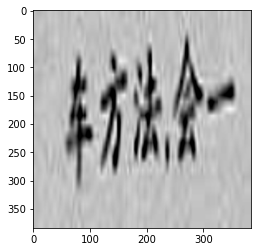

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset[0]['pixel_values'].permute(1, 2, 0))
plt.show

In [ ]:
pix = torch.tensor(train_dataset[0]['pixel_values'])
pixel_values = torch.unsqueeze(input=pix, dim=0)
pixel_values.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


torch.Size([1, 3, 384, 384])

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pixel_values = pixel_values.to(device)

In [ ]:
# autoregressively generate caption (uses greedy decoding by default)
generated_ids = model.generate(pixel_values, max_new_tokens=50)
generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

车 方 法, 会 一


## training works for one sample

## - but we don't reach 100% accuracy even for one sample, probably we need to implement lr decay, this should be our second step, that is achieve 100% accuracy on a single sample
DONE

## - next step would be to use a proper lr scheduler to decay the learning rate properly and get good accuracy on these 2 samples

DONE